In [41]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
df = pd.read_csv("../data/historic_demand_2009_2023.csv")

In [33]:
df = df[192_816:]

In [34]:
df.head()

Unnamed: 0 settlement_date  settlement_period     nd    tsd  \
192816      192816      2020-01-01                  1  26340  27153   
192817      192817      2020-01-01                  2  26921  27684   
192818      192818      2020-01-01                  3  26569  27240   
192819      192819      2020-01-01                  4  25754  26435   
192820      192820      2020-01-01                  5  25075  25824   

        england_wales_demand  embedded_wind_generation  \
192816                 23821                      1244   
192817                 24393                      1188   
192818                 24085                      1156   
192819                 23350                      1125   
192820                 22788                      1106   

        embedded_wind_capacity  embedded_solar_generation  \
192816                    6465                          0   
192817                    6465                          0   
192818                    6465                          0   
192819                    6465                          0   
192820                    6465                          0   

        embedded_solar_capacity  ...  pump_storage_pumping  ifa_flow  \
192816                    13080  ...                    15      1703   
192817                    13080  ...                    17      1703   
192818                    13080  ...                    18      1703   
192819                    13080  ...                    15      1703   
192820                    13080  ...                    15      1704   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
192816          0           852        -151             -47        854   
192817          0           853        -146               0        854   
192818          0           852         -53               0        854   
192819          0           852         -66               0        854   
192820          0           853         -74             -60        854   

        nsl_flow  eleclink_flow  is_holiday  
192816       0.0            0.0           1  
192817       0.0            0.0           1  
192818       0.0            0.0           1  
192819       0.0            0.0           1  
192820       0.0            0.0           1  

[5 rows x 21 columns]

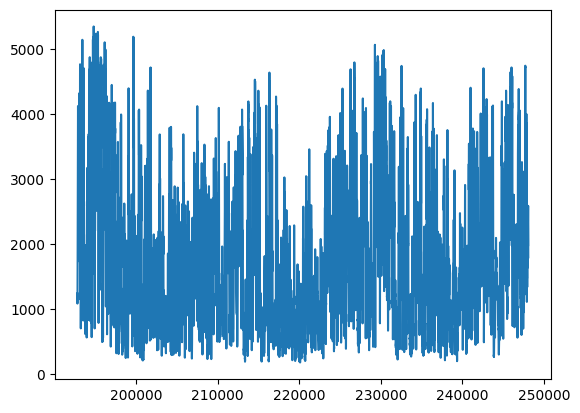

In [35]:
plt.plot(df.embedded_wind_generation)

In [61]:
train = df.embedded_wind_generation[:35_000]
test = df.embedded_wind_generation[35_000:]

In [62]:
train.shape

(35000,)

In [63]:
smodel = pm.auto_arima(train, seasonal=True, m=12, 
                       start_p=0, max_p=1, max_d=1, start_q=0, max_q=1,
                       start_P=0, max_P=2, max_D=1, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=430783.654, Time=0.37 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=430695.115, Time=3.45 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=430718.573, Time=5.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=430781.663, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=430694.236, Time=0.46 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=430695.035, Time=3.55 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=430697.671, Time=4.17 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=429228.817, Time=6.29 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=429217.175, Time=23.84 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=429216.578, Time=97.23 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=429217.751, Time=105.15 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=429216.381, Time=43.36 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=429216.930, Time=25.36 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=429217.856,

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(train, order=(1, 1, 0), seasonal_order=(1, 0, 1, 12))
sarima = sarima.fit(maxiter=75)

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15268D+00    |proj g|=  1.39110D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2      4      1     0     0   6.817D-05   6.153D+00
  F =   6.1526811275951436     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [65]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

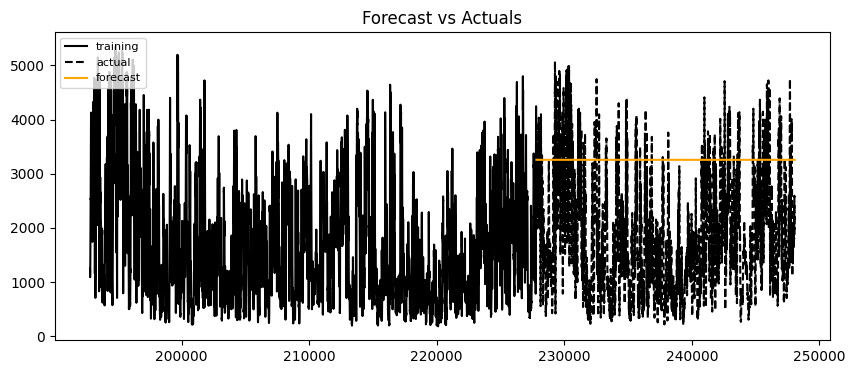

In [66]:
forecast_recons = pd.Series(forecast, index=test.index)

plot_forecast(forecast_recons,train, test)